In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
import librosa.feature
from PIL import Image
import os
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error

In [3]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super(ResBlock, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))

        self.l1 = nn.Sequential(
            nn.BatchNorm2d(ch),
            nn.Conv2d(ch,ch,3,padding=1)
        )

        self.l2 = nn.Sequential(
            nn.BatchNorm2d(ch),
            nn.Conv2d(ch,ch,3,padding=1)
        )

    def forward(self, x):
        return x + self.gamma*self.l2(self.l1(x))

In [4]:
base_model = nn.Sequential(
    nn.Conv2d(1,16,3,padding=1),
    nn.LeakyReLU(),
    ResBlock(16),
    nn.Conv2d(16,64,3,padding=1),
    nn.LeakyReLU(),
    ResBlock(64),
    nn.Conv2d(64,64,3,padding=1),
    nn.LeakyReLU(),
    ResBlock(64),
    nn.Conv2d(64,1,1),
)

In [5]:
class SuperRes(nn.Module):
    def __init__(self, base_model):
        super(SuperRes, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.base_model = base_model
    def forward(self,x):
        return x + self.gamma*self.base_model(x)

In [6]:
model = SuperRes(base_model).cuda()

In [8]:
class DenoiseData(torch.utils.data.Dataset):
    def __init__(self, path_data):
        self.path_data = path_data
        self.files_data = os.listdir(self.path_data + 'noisy/')
        self.files_data.sort()
        self.files_target = os.listdir(self.path_data + 'clear')
        self.files_target.sort()
        self.all_paths_data = [self.path_data + 'noisy/' + name for name in self.files_data]
        self.all_paths_target = [self.path_data + 'clear/' + name for name in self.files_target]
    def __len__(self):
        return len(self.files_data)
    def __getitem__(self, idx):
        data = spec2image(np.load(self.all_paths_data[idx]).T)
        target = spec2image(np.load(self.all_paths_target[idx]).T)
        if data.shape[1] <= 200:
            data_crop = np.zeros((80,200))
            target_crop = np.zeros((80,200))
            data_crop[:data.shape[0],:data.shape[1]] = data
            target_crop[:target.shape[0],:target.shape[1]] = target
        else:
            rand_coord = np.random.randint(0, data.shape[1]-200)
            data_crop = data[:, rand_coord:rand_coord+200]
            target_crop = target[:, rand_coord:rand_coord+200]
        data_crop = torch.FloatTensor(data_crop).unsqueeze(0)
        target_crop = torch.FloatTensor(target_crop).unsqueeze(0)
        data_crop.requires_grad_(True)
        target_crop.requires_grad_(True)
        return data_crop, target_crop

train_data = DenoiseData('/content/gdrive/My Drive/train/')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_data = DenoiseData('/content/gdrive/My Drive/validate/')
val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), shuffle=True)

OSError: ignored

In [12]:
def spec2image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled

Epoch:  11


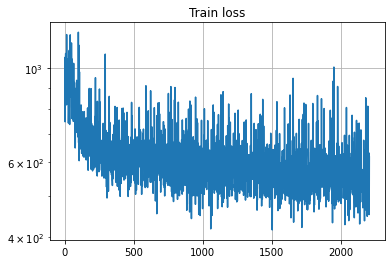

 74%|███████▍  | 140/188 [05:35<01:53,  2.37s/it]

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 100
train_loss = []

for epoch in range(num_epochs):
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()

        optimizer.zero_grad()

        predict = model(X_batch)

        loss = nn.MSELoss()(predict,y_batch)
        loss.backward()    

        optimizer.step()

        # with torch.no_grad():
        #     for x, y in val_loader:
        #         x = x.cuda()
        #         y = y.cuda()
        #         val_predict = model(x)

        error = loss.item()
        train_loss.append(error)
        clear_output(True)

        # val = mean_squared_error(y.detach().cpu().numpy(), val_predict.detach().cpu().numpy())
        print('Epoch: ', epoch)
        # plt.figure(figsize=(10,5))
        # plt.subplot(121)
        plt.semilogy(train_loss)
        plt.title('Train loss')
        plt.grid()
        # plt.subplot(122)
        # plt.plot(roc)
        # plt.title('Validation MSE')
        # plt.grid()
        plt.show()
    torch.save(model, '/content/gdrive/My Drive/denoise_model')